### Package


ot won't import. install POT. ot still won't import . reinstall numpy --> forced restart runtime. import ot worked. wasserstein distance works!

In [1]:
!pip install POT
!pip install --upgrade numpy

     |████████████████████████████████| 656 kB 5.0 MB/s 
     |████████████████████████████████| 15.7 MB 39.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:

!pip install gudhi
!pip install tensorflow_addons
!pip install git+https://github.com/master/tensorflow-riemopt.git


     |████████████████████████████████| 29.3 MB 81.8 MB/s 
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Cloning https://github.com/master/tensorflow-riemopt.git to /tmp/pip-req-build-mn067tey
  Running command git clone -q https://github.com/master/tensorflow-riemopt.git /tmp/pip-req-build-mn067tey
  Created wheel for tensorflow-riemopt: filename=tensorflow_riemopt-0.1.0-py3-none-any.whl size=45244 sha256=6a51f0b5d2041f1b2dcfe5f927cd62257b305157b895282a33441172e95f345c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ywe0ch79/wheels/f5/3c/6c/a6eebf4b391b6af4cb01f873345d494c35c02b3883636d1a94
Successfully built tensorflow-riemopt


In [ ]:
!pip install eagerpy

In [2]:
import numpy               as np
import tensorflow          as tf
import tensorflow_addons   as tfa
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd


from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

# Data Generation

## 1 Cylinder 

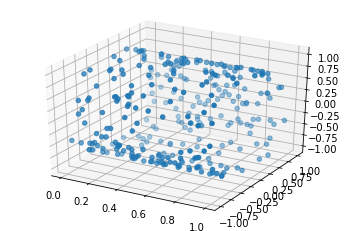

In [ ]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
plt.show()

## 2 Cylinders

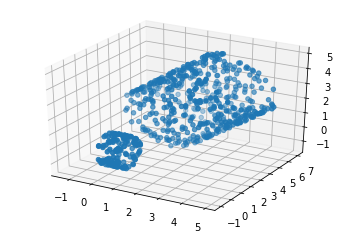

In [ ]:
#Questions:
#1. Why does it look like a half cylinder? 


np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back

ss3=np.random.uniform(0,2*np.pi,150)
noise=np.random.normal(0,0.1,150) #add noise if you want

#small cylinder
noise=0 #cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)




rr3=np.random.uniform(0,1,150) 

np.random.seed(100)
sss3=np.random.uniform(0,2*np.pi,500)
xxx=3+2*np.cos(sss3)
yyy=2*np.sin(sss3)


xxx45=2+xxx #how far apart the cylinders are 


rrr3=np.random.uniform(0,5,500) 

#rotate by 45 degree
rrr45=rrr3*np.sqrt(2)/2-np.sqrt(2)/2*yyy
yyy45=rrr3*np.sqrt(2)/2+np.sqrt(2)/2*yyy


#np.r_ concatenate 
RR=np.r_[rr3,rrr45]  #points on one axis
RX=np.r_[xx,xxx] #not used
RY=np.r_[yy,yyy] #not used

RX45=np.r_[xx,xxx45] #points on one axis
RY45=np.r_[yy,yyy45] #points on one axis

ax = plt.subplot(111, projection='3d')
ax.scatter(RR,RX45,RY45) 
# ax.scatter(RR,RX,RY) 
plt.show()

#try rotating plot to see different angles 

### Creating X

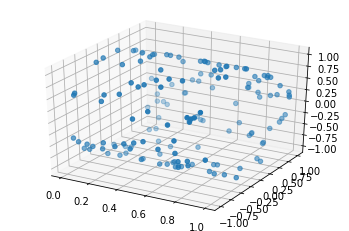

In [ ]:
#data for singular cylinder 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)

ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
plt.show()

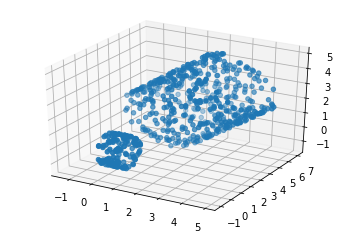

In [ ]:
#data for two cylinders
X=np.array(np.mat([RR,RX45,RY45]).T,dtype=np.float32)

ax = plt.subplot(111, projection='3d')
ax.scatter(RR,RX45,RY45) 
plt.show()

# `RipsModel` Class: Translating Persistence Diagrams into TensorFlow

In [3]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        Z=X@self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

# Testing Wasserstein Distance

In [ ]:
st = gd.RipsComplex(points = X, 
                    max_edge_length = 100).create_simplex_tree(max_dimension=2)
st.persistence() #computes persistence intervals

#extract persistence intervals for specified dim
D = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)

In [ ]:
#the perfect circle case
# remove x axis
st1 = gd.RipsComplex(points = X@np.array([[0,  0],
       [1 , -0 ],
       [ 0. , 1]]), 
                    max_edge_length=12).create_simplex_tree(max_dimension=2)
st1.persistence()
D1 = np.array(st1.persistence_intervals_in_dimension(1), dtype=np.float32)

In [ ]:
# wasserstein distance between the two pd diagrams above
wasserstein_distance(tf.constant(D1), tf.constant(D), order=2, internal_p=2)
# wasserstein_distance(tf.constant(D1), tf.constant(D), order=2, internal_p=2)

0.37352108178185484

# Zhaoyang's Sinkhorn

## lr=10 fixed

In Paper:

```

m = 3 n = 2
x (vector) in R^3, we have 300 x vectors
P in R^(mxn) = R^(3x2)
Pinit in R^(3x2)


P^T X --> Xp???

P^T x = (2x3)(3x1) = (2x1)

P^T X = (2x3)(3x300) = (2x300)

which is equivalent to Pinit.T @X.T = (2x300)  --> row of xs, row of ys


````


Our X is actually (300x3): 

```

X P = (300x3) * (3x2) = (300x2)

```

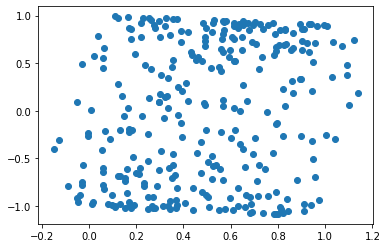

In [ ]:
# Question: by P = u @ vh instead of P = u or P = vh?
# Comment: Our P different from Zhaoyang's P

#construct Stiefel manifold
S = manopt.manifolds.StiefelCanonical() #Stiefel manifold with the canonical metric, canonical = conventional
np.random.seed(100)

#random P in Stiefel manifold as the initialized, P = projection matrix on manifold
H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False) #u, vh orthogonal matricies
P = u @ vh  #initalize P, multiplying orthog * orthong = orthog P is 3x2

# (P^T)*P = I
# (vh)^T u^T u vh 
# u^T u = I bc u orthogonal matrix
#(vh)^T vh = I bc vh orthogonal matrix 


'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''

''' our P matrix is different from the one above
P
array([[ 0.98601284, -0.09638477],
       [ 0.12083232,  0.9753061 ],
       [-0.11479647,  0.19871586]])
'''


#convert it into tensor with float 32
Pinit = np.array(P, dtype=np.float32) 
P = tf.Variable(initial_value=Pinit, trainable=True) #make P tensorflow variable, trainable = True 

#assign the initialized P
manopt.variable.assign_to_manifold(P, S) #make P cananonical steifel manifold 

#construct main model and optimization model
model = RipsModel(P=P, mel=12, dim=1, card = 20) #model class instance

opt = manopt.optimizers.RiemannianSGD(learning_rate= 10) #Optimizer that implements the Riemannian SGD algorithm, class instance

#show the initialized transformed data
data=X@Pinit #project data 
x2=data[:,0].tolist() #column 1 = x values
y2=data[:,1].tolist() #column 2 = y values
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

**Gradient Descent:**

Start with P and a certain learning rate (how big steps are in gradient descent, does step size change within an epoch???).

Larger learning rate = faster learning but increases chances of overshooting/not reaching the min

Smaller learning rate = slower, but less chances of overshooting min

Each epoch decreases the learning rate. 
So start with a larger learning rate because the learning is faster. With each epoch, decrease the learning rate --> learning becomes slower but more accurate. When min loss converges, stop running epochs. 

0.09505964


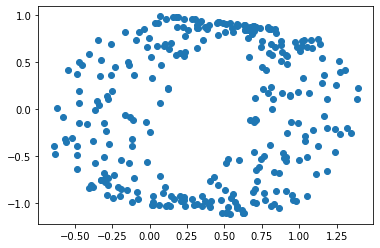

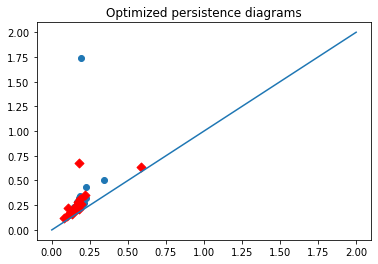

KeyboardInterrupt: ignored

In [ ]:
#Question: Where is the P being updated? Is it bc of tf.Variable (trainaible=True)? 
#unless same P is being used at the beginning of each epoch

#Question: What is the point of having 5 epochs if the learning rate isn't changing?

#Question: difference between epoch vs iteration of gradient descent, especially if lr isn't changing?

#keep track of loss and persistence diagrams after projection
losses, dgms = [], []

#lr = 10, learning rate
for epoch in range(4+1):#learning iteration, 5 times 
    #opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    #lr = 0.05*lr

    #Question: how many times does gradient descrent run? until what. 

    #Inside this scope, we call the model (forward pass) and compute the loss
    with tf.GradientTape() as tape:#computing gradient
        
        # Compute persistence diagram
        Zdgm = model.call()[1] #projected persistence diagram
        Xdgm = model.call()[0] #original persistence diagram
        npX = np.array(Xdgm)
        npZ = np.array(Zdgm)
        
        #Question: Why are all these functions defined in the loop? Can we take them out? 

        #computing Sinkhorn distance <<<- estimation of wasserstein
        def dmat(x, y):
            """
            :param x: (na, 2)
            :param y: (nb, 2)
            :return:
            """
            mmp1 = tf.tile(tf.expand_dims(x, axis=1), [1, y.shape[0], 1])  # (na, nb, 2)
            mmp2 = tf.tile(tf.expand_dims(y, axis=0), [x.shape[0], 1, 1])  # (na, nb, 2)

            mm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(mmp1, mmp2)), axis=2))  # (na, nb)

            return mm
        
        def sink(M, m_size, reg, numItermax=1000, stopThr=1e-9):
            # we assume that no distances are null except those of the diagonal of distances
            # M: extended cost matrix
            # reg: lambda

            a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
            b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

            # init data
            Nini = m_size[0]
            Nfin = m_size[1]

            u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
            v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

            K = tf.exp(-M / reg)  # (na, nb)

            Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

            cpt = tf.constant(0)
            err = tf.constant(1.0)

            c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

            def err_f1():
                # we can speed up the process by checking for the error only all the 10th iterations
                transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
                err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
                return err_

            def err_f2():
                return err

            def loop_func(cpt, u, v, err):
                KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
                v = tf.compat.v1.div(b,KtransposeU)  # (nb, 1)
                u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

                err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

                cpt = tf.add(cpt, 1)
                return cpt, u, v, err

            _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

            result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

            return result
        
        A=np.array([[1,-1],[-1,1]])
        # Compute persistence diagram

        
        # Loss is sum of squares of distances to the diagonal
        Morginal = dmat(Xdgm,Zdgm)
        
        n1,n2 = Morginal.shape
        Deltax=np.zeros(shape=(n1,1))
        Deltaz=np.zeros(shape=(1,n2+1))
        
        for i in range(n1):
            Deltax[i,0] = 1/2*npX[i,:]@A@npX[i,:].T
            
        for j in range(n2):
            Deltaz[0,j] = 1/2*npZ[j,:]@A@npZ[j,:].T
            

        M=tf.square(tf.concat([tf.concat([Morginal,Deltax],1),Deltaz],0))
        
        # Sinkhorn distance as loss
        loss = sink(M,(n1+1,n2+1),0.05)
        

    #Question: clarification,  loss used in gradients descent is sinkhorn distance?

    # Compute and apply gradients
    #Outside the scope, we retrieve the gradients of the weights of the model with regard to the loss

    #Question: what is the weights in our case? The P?
    gradients = tape.gradient(loss, model.trainable_variables)
    
    #Finally, we use the optimizer to update the weights of the model based on the gradients
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    #loss
    print(loss.numpy())
    
    #persistence diagrams after transformation
    losses.append(loss.numpy()) #keeps tack of all losses 
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow) #keep track of persistence diagrams
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        
        # ax = plt.subplot(111, projection='3d')
        # ax.scatter(x2,y2,0) 
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

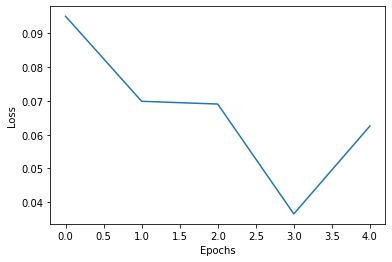

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## lr=15 decaying 0.05 rate

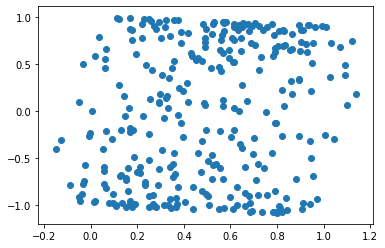

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 20)

opt = manopt.optimizers.RiemannianSGD(learning_rate= 10)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

0.09505963


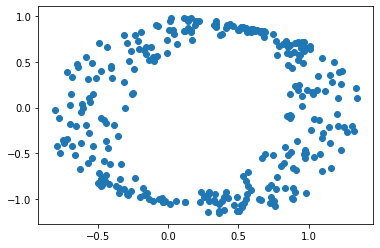

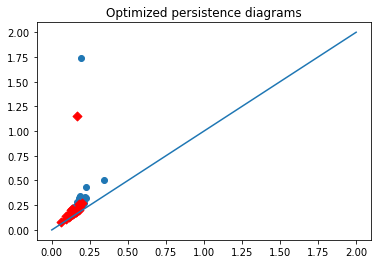

0.039388


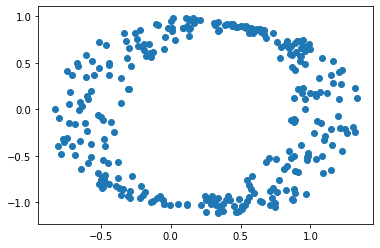

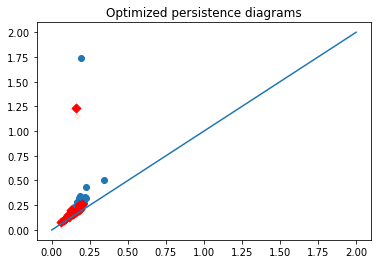

0.036963798


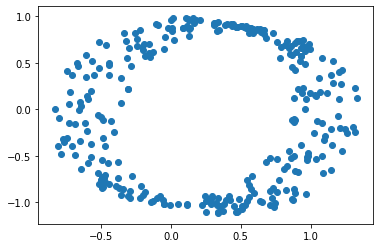

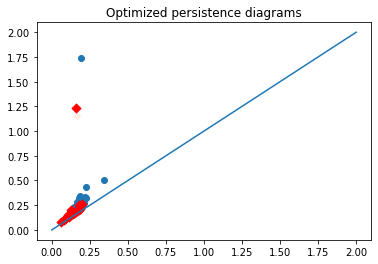

0.036868192


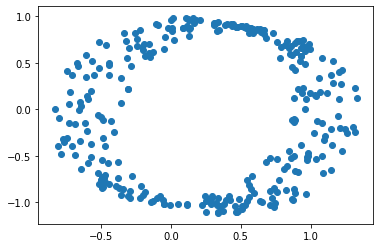

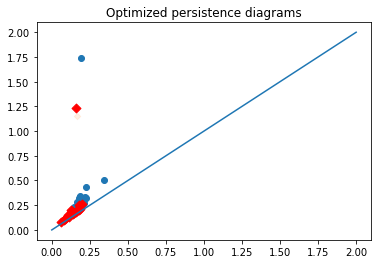

0.036863536


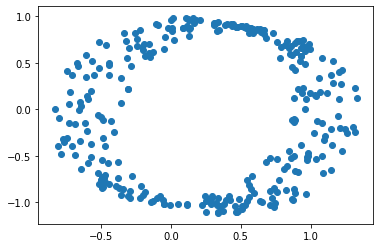

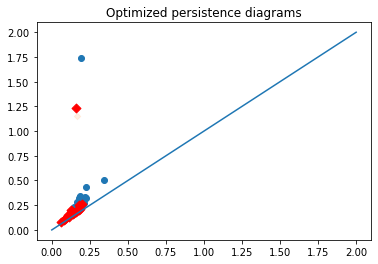

In [ ]:
losses, dgms = [], []
lr = 15
for epoch in range(4+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    #decaying lr
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        npX = np.array(Xdgm)
        npZ = np.array(Zdgm)
                
        def dmat(x, y):
            """
            :param x: (na, 2)
            :param y: (nb, 2)
            :return:
            """
            mmp1 = tf.tile(tf.expand_dims(x, axis=1), [1, y.shape[0], 1])  # (na, nb, 2)
            mmp2 = tf.tile(tf.expand_dims(y, axis=0), [x.shape[0], 1, 1])  # (na, nb, 2)

            mm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(mmp1, mmp2)), axis=2))  # (na, nb)

            return mm
        
        def sink(M, m_size, reg, numItermax=1000, stopThr=1e-9):
            # we assume that no distances are null except those of the diagonal of distances

            a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
            b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

            # init data
            Nini = m_size[0]
            Nfin = m_size[1]

            u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
            v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

            K = tf.exp(-M / reg)  # (na, nb)

            Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

            cpt = tf.constant(0)
            err = tf.constant(1.0)

            c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

            def err_f1():
                # we can speed up the process by checking for the error only all the 10th iterations
                transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
                err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
                return err_

            def err_f2():
                return err

            def loop_func(cpt, u, v, err):
                KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
                v = tf.compat.v1.div(b,KtransposeU)  # (nb, 1)
                u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

                err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

                cpt = tf.add(cpt, 1)
                return cpt, u, v, err

            _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

            result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

            return result
        
        A=np.array([[1,-1],[-1,1]])
        # Compute persistence diagram

        
        # Loss is sum of squares of distances to the diagonal
        Morginal = dmat(Xdgm,Zdgm)
        
        n1,n2 = Morginal.shape
        Deltax=np.zeros(shape=(n1,1))
        Deltaz=np.zeros(shape=(1,n2+1))
        
        for i in range(n1):
            Deltax[i,0] = 1/2*npX[i,:]@A@npX[i,:].T
            
        for j in range(n2):
            Deltaz[0,j] = 1/2*npZ[j,:]@A@npZ[j,:].T
            
        '''    
        for i in range(n1):
            Deltax[i,0] = (npX[i,1]-npX[i,0])**2
            
        for j in range(n2):
            Deltaz[0,j] = (npZ[i,1]-npZ[i,0])**2
        '''
        
        M=tf.square(tf.concat([tf.concat([Morginal,Deltax],1),Deltaz],0))
        
        loss = sink(M,(n1+1,n2+1),0.05)
        
        # Loss is Wasserstein distance
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

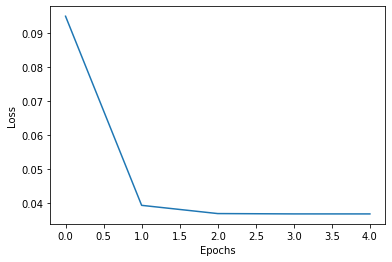

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Zhaoyang's Wasserstein 

## lr=10 decay rate 0.05

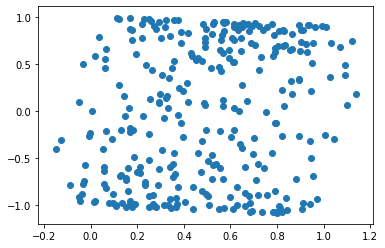

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

'''initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
'''
#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

1.3082482


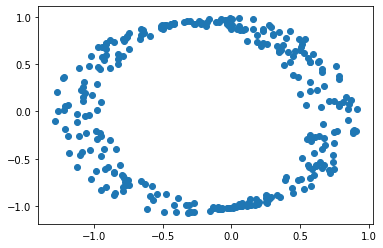

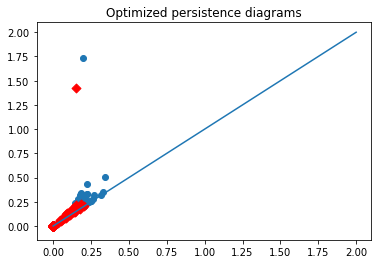

0.22922142


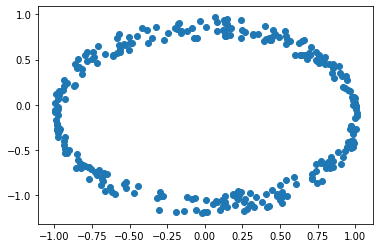

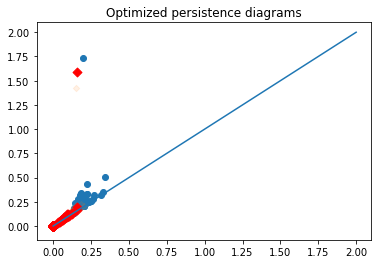

0.1579488


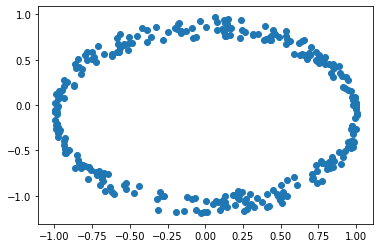

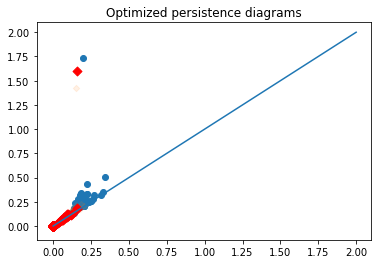

0.1551687


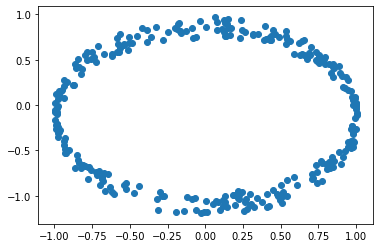

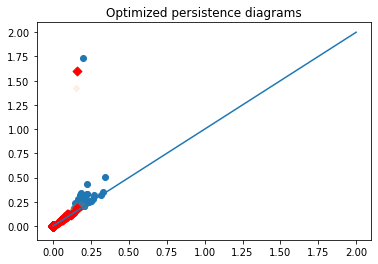

0.15505809


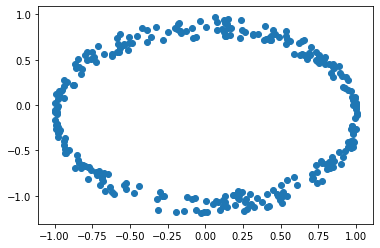

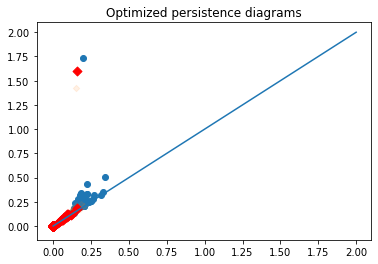

In [ ]:
losses, dgms = [], []
lr = 10
for epoch in range(4+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

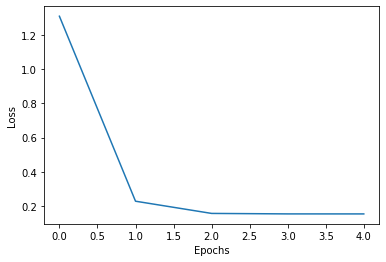

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## lr=5 decay rate 0.05

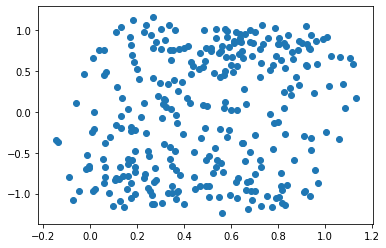

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

#sigma=0.1

0.77862054


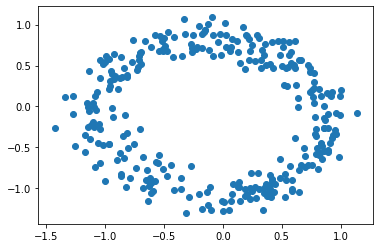

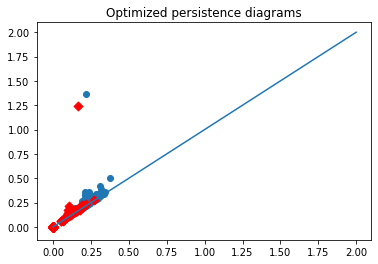

0.13177744


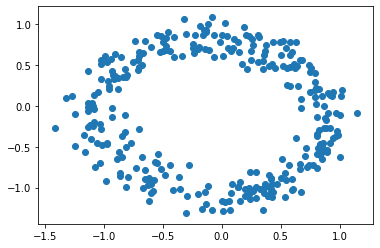

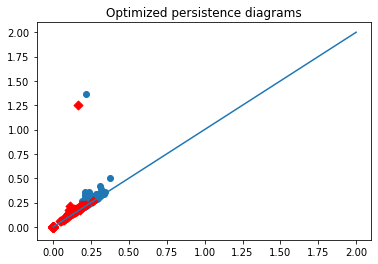

0.12985894


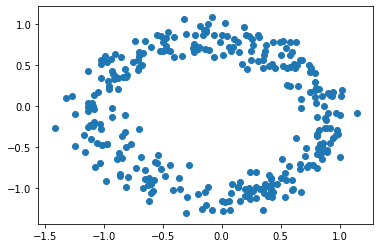

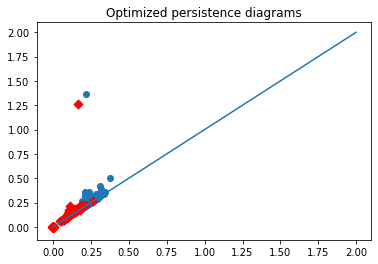

0.12918437


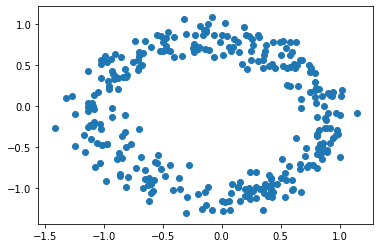

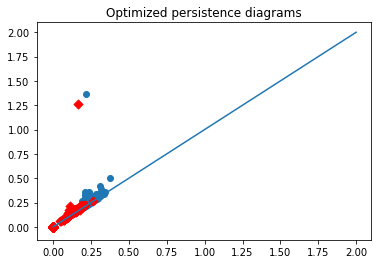

0.12914607


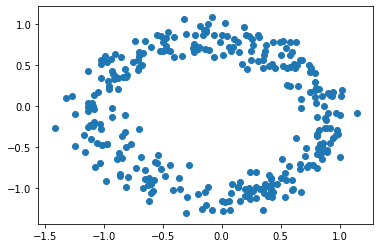

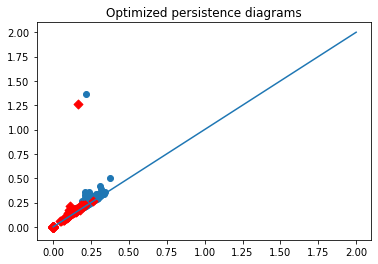

0.1291442


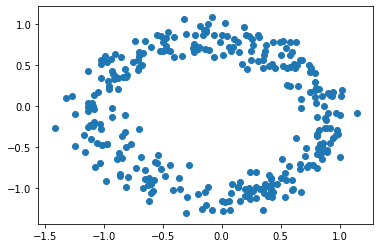

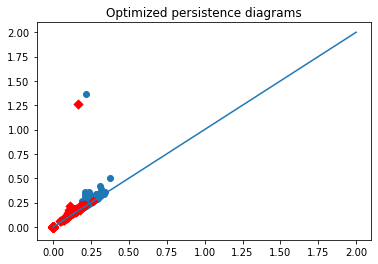

0.12914394


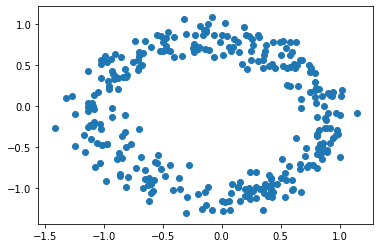

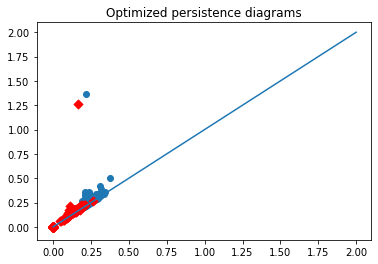

0.12914394


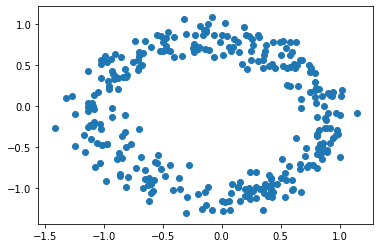

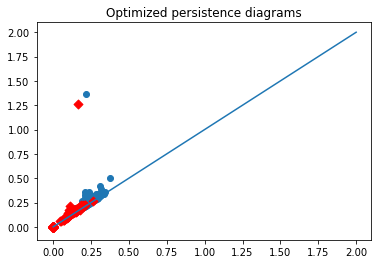

0.12914394


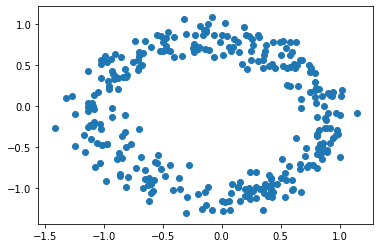

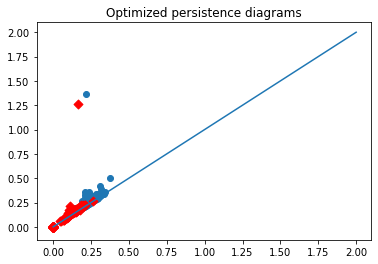

0.12914394


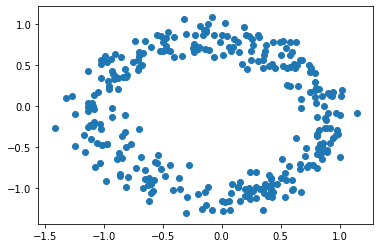

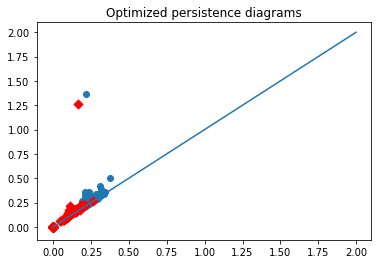

0.12914394


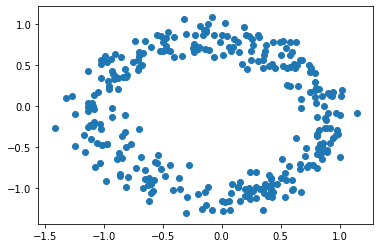

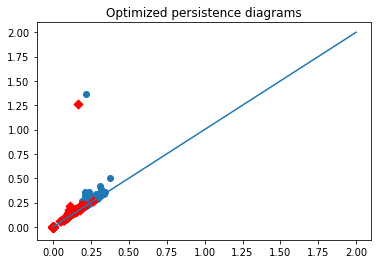

0.12914394


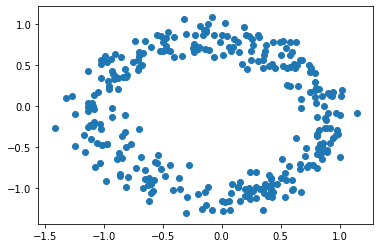

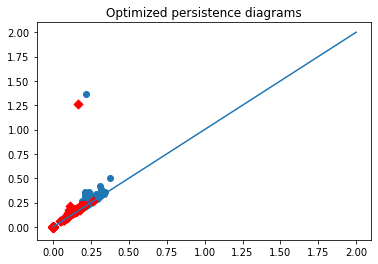

0.12914394


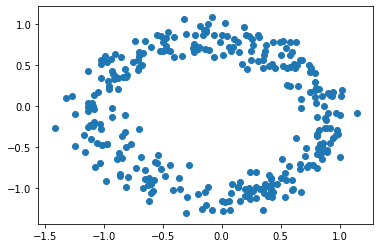

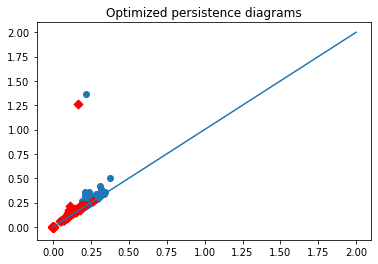

0.12914394


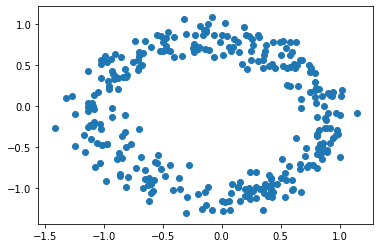

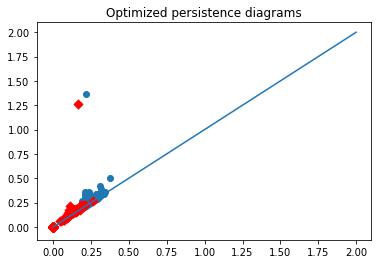

0.12914394


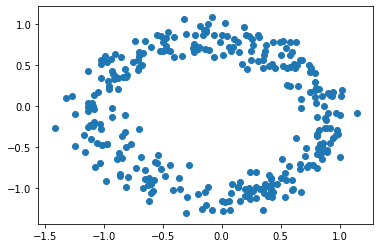

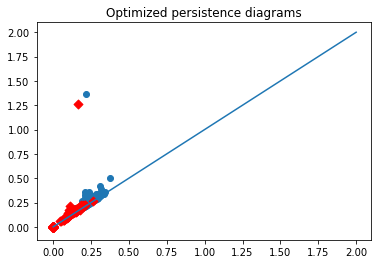

0.12914394


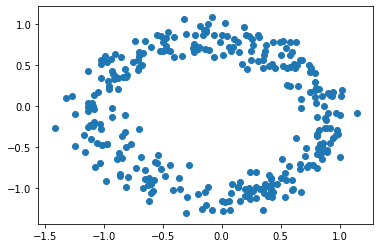

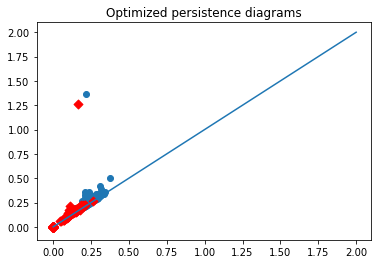

0.12914394


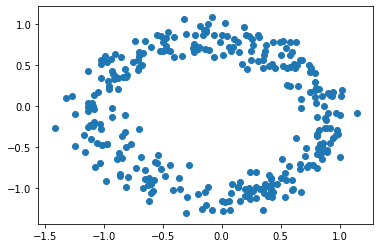

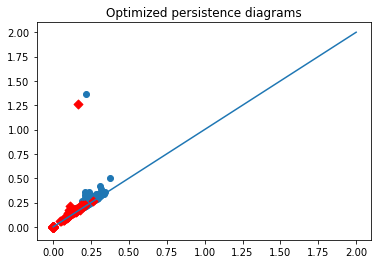

0.12914394


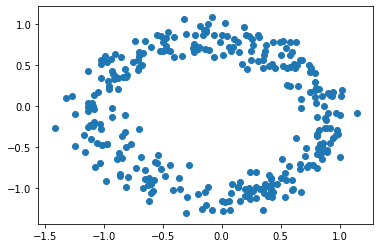

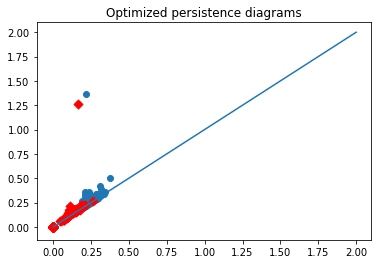

0.12914394


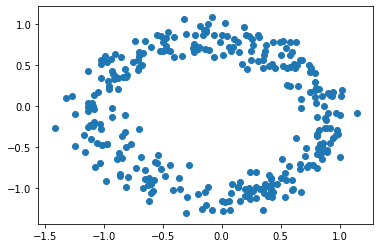

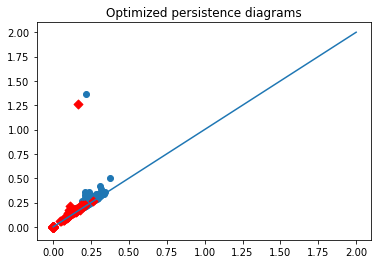

0.12914394


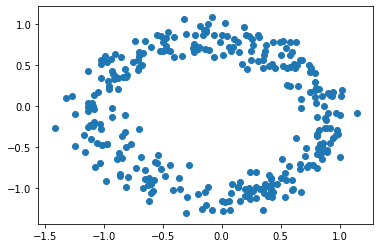

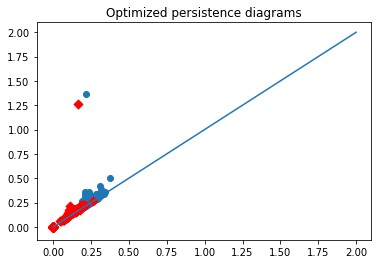

0.12914394


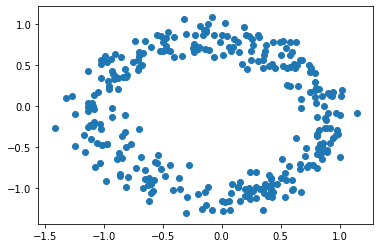

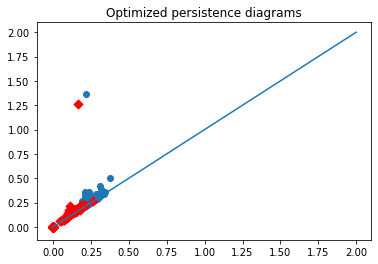

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(20+1):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

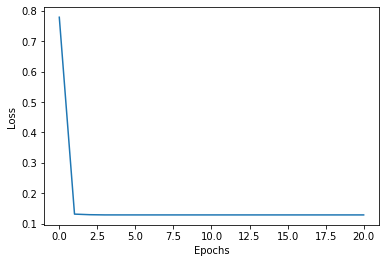

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# 2 cylinders CASE 1

###lr = 5, decay rate = 0.05 Zhaoyang

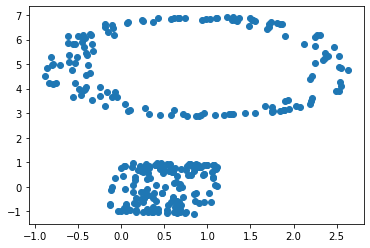

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

1.8939562


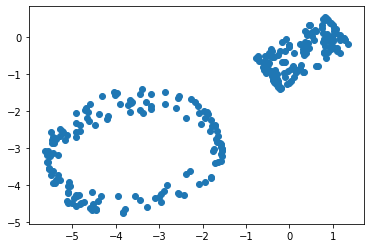

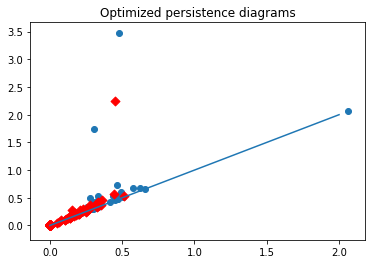

2.6097794


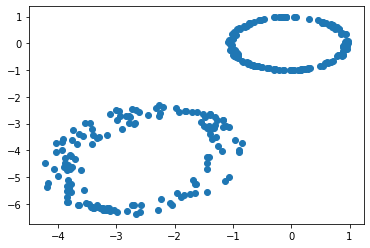

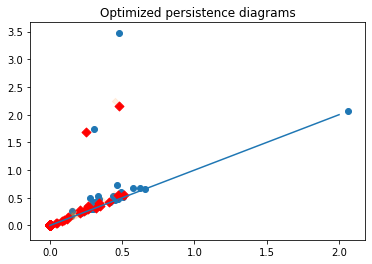

1.8519737


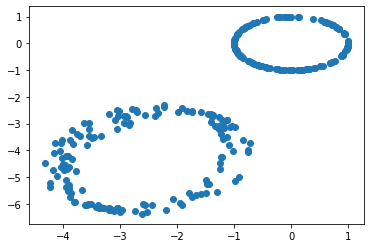

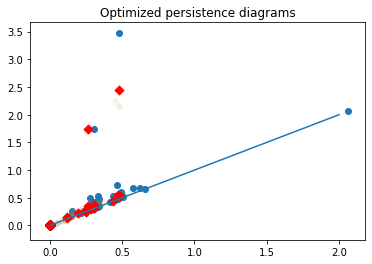

1.2056185


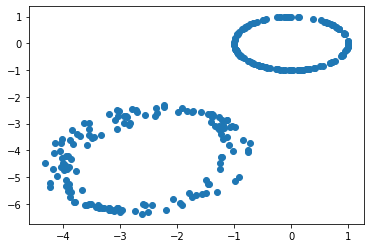

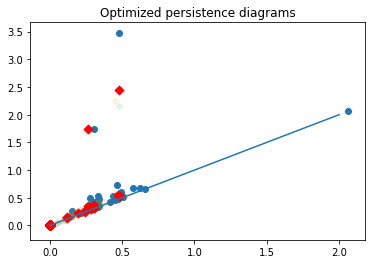

1.1861433


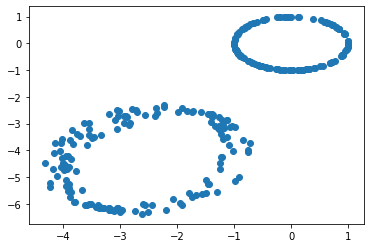

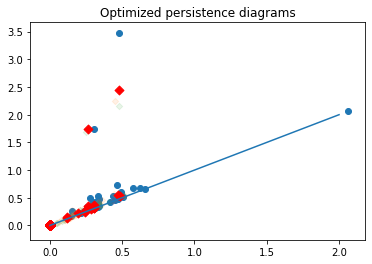

1.1851778


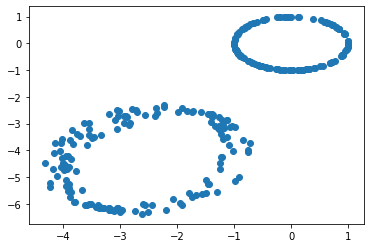

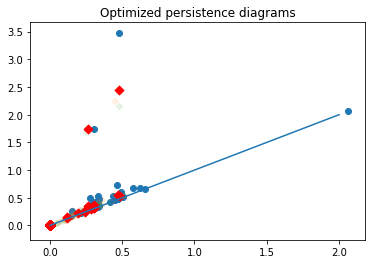

1.1851292


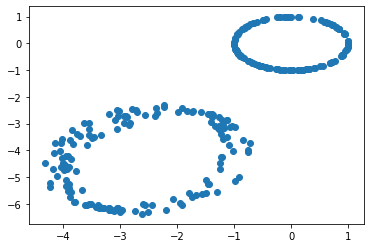

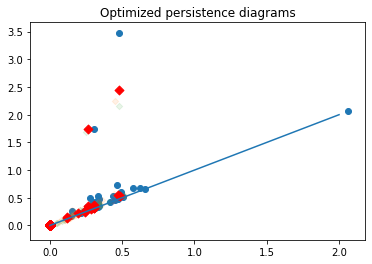

1.1851271


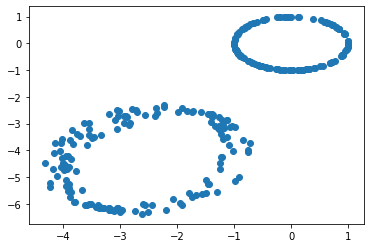

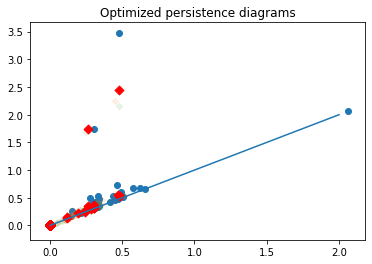

1.1851256


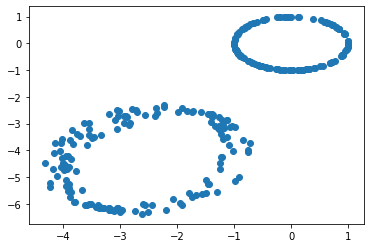

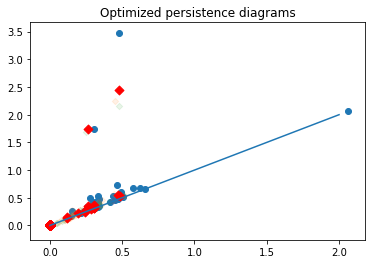

1.1851256


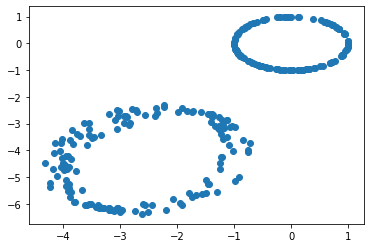

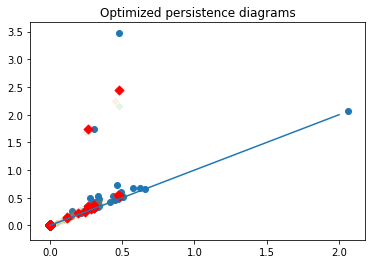

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(10):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        # for dg in dgms:
        #     plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

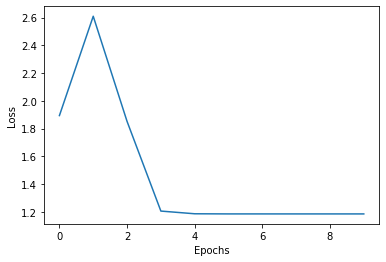

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

###lr = 5, decay rate = 0.05

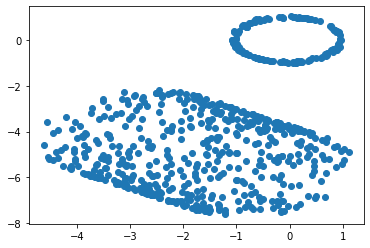

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
# P = u @ vh  #initalize P

P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])

Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

5.5446553


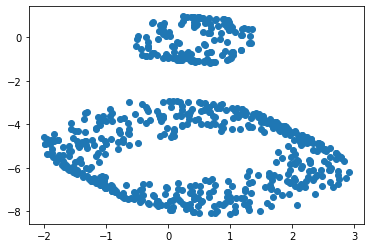

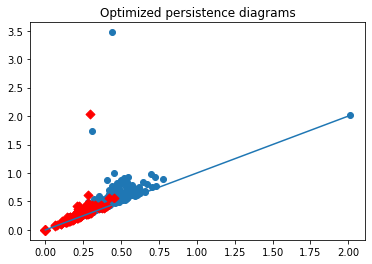

4.8343935


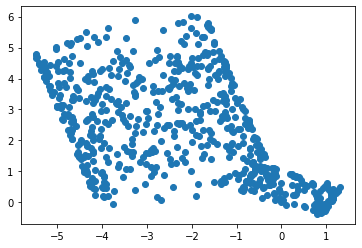

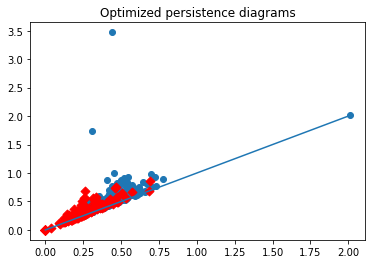

6.865099


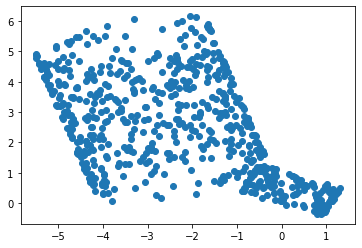

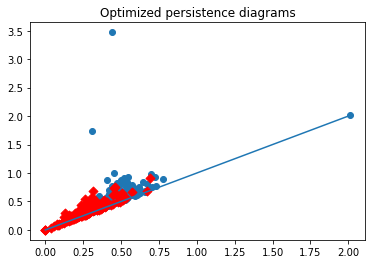

6.7655883


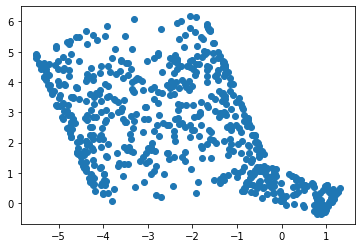

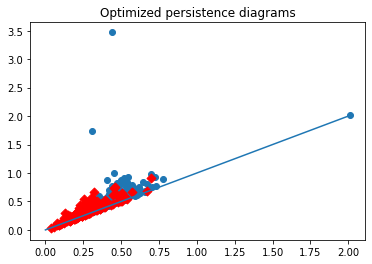

6.7410355


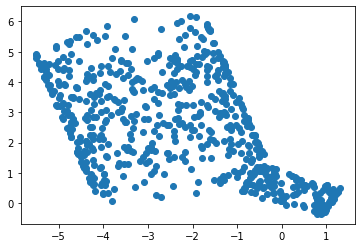

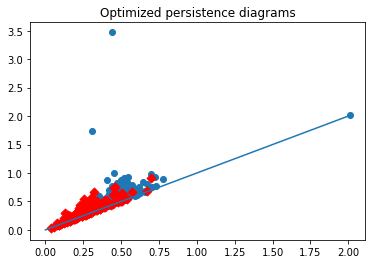

6.7399697


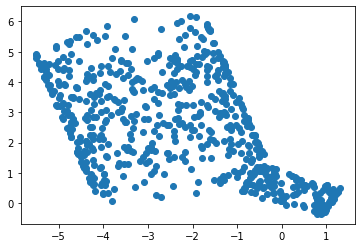

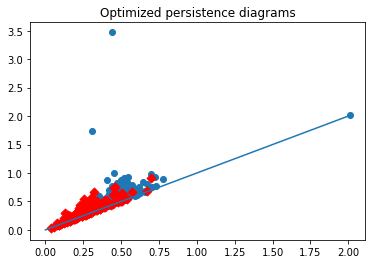

6.7399015


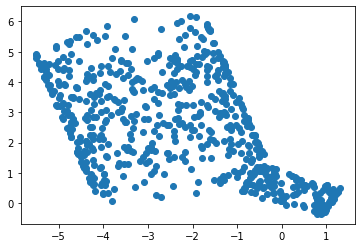

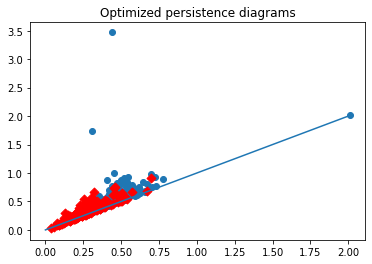

6.7399063


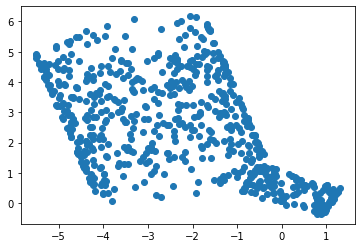

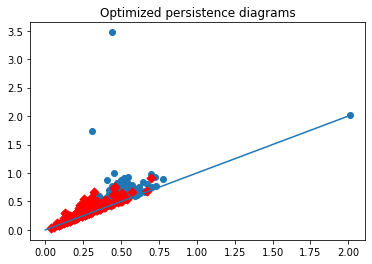

6.739899


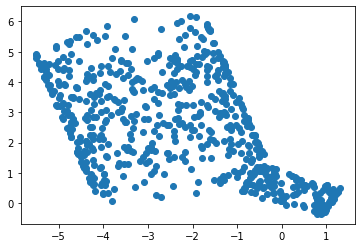

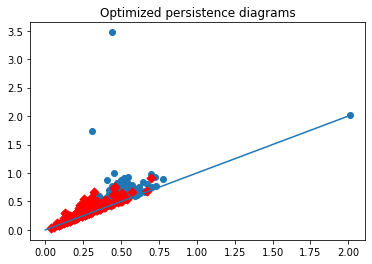

6.739899


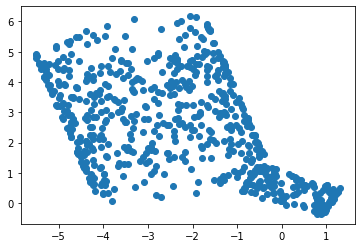

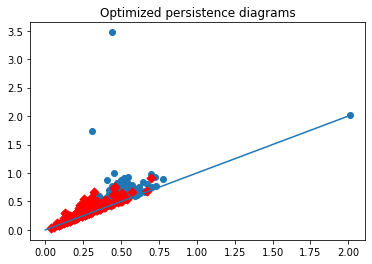

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(10):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        # for dg in dgms:
        #     plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

###lr = 10, decay = 0.05

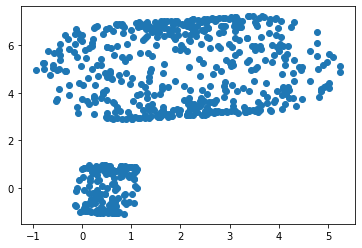

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

6.744515


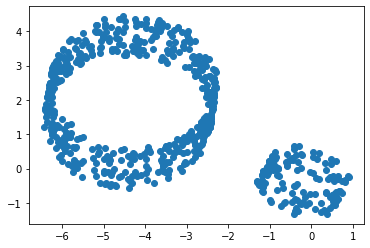

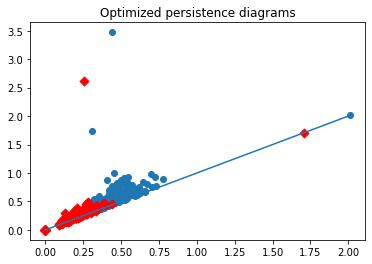

3.528248


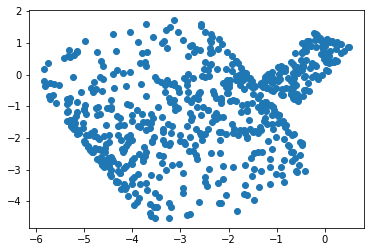

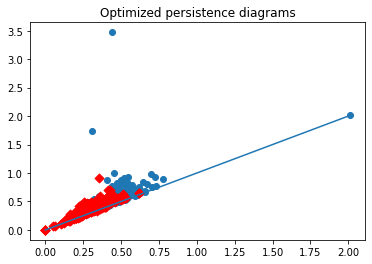

6.562459


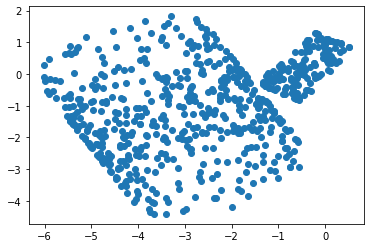

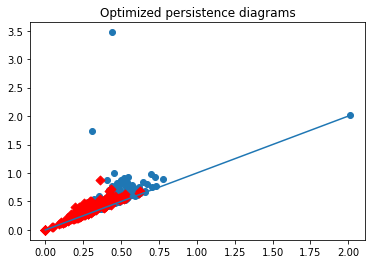

6.6202035


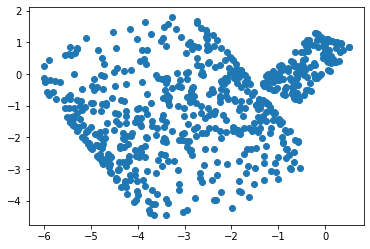

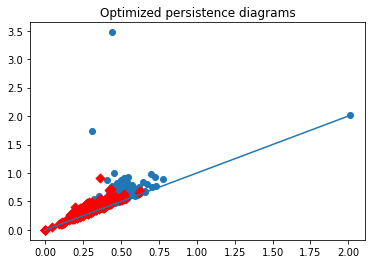

6.5729084


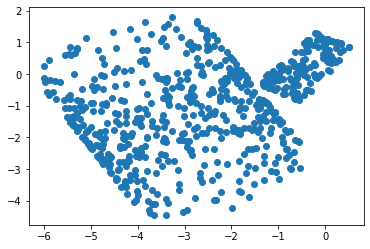

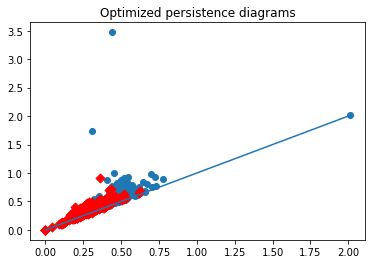

6.571329


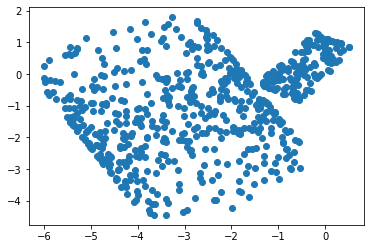

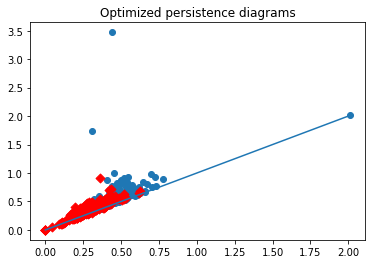

6.5713043


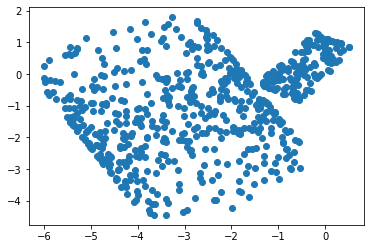

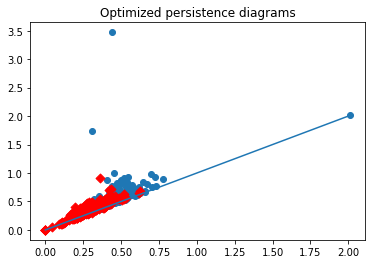

6.571301


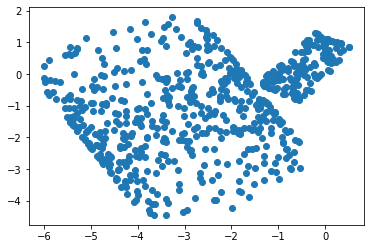

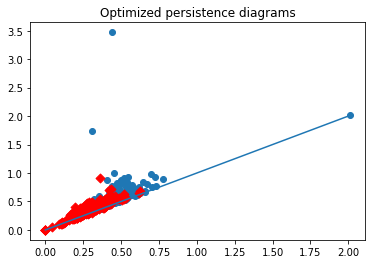

6.571301


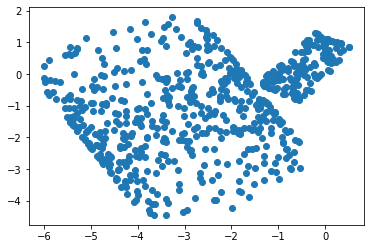

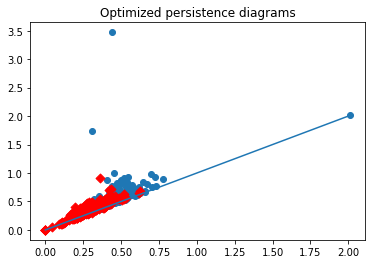

6.571301


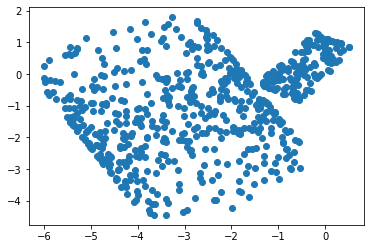

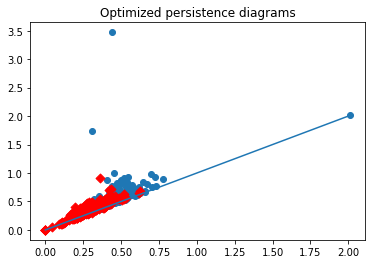

In [ ]:
losses, dgms = [], []
lr = 10
for epoch in range(10):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    lr = 0.05*lr

    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        # for dg in dgms:
        #     plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

# 2 cylinders CASE 2

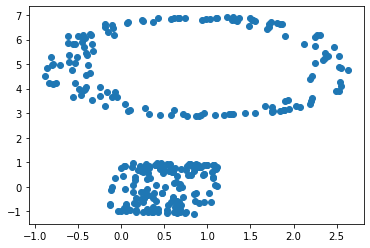

In [ ]:
S = manopt.manifolds.StiefelCanonical()
np.random.seed(100)

H = np.random.rand(3, 2)
u, s, vh = np.linalg.svd(H, full_matrices=False)
P = u @ vh  #initalize P
'''
P = np.array([[-0.0984759 ,  0.07432846],
       [-0.5994593 , -0.8004051 ],
       [ 0.7943243 , -0.59483355]])
'''
Pinit = np.array(P, dtype=np.float32)

P = tf.Variable(initial_value=Pinit, trainable=True)

manopt.variable.assign_to_manifold(P, S)

model = RipsModel(P=P, mel=12, dim=1, card = 150)

initial_learning_rate = 0.9
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)

#opt = manopt.optimizers.RiemannianSGD(learning_rate = 5)

data=X@Pinit
x2=data[:,0].tolist()
y2=data[:,1].tolist()
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()
        

1.8939562


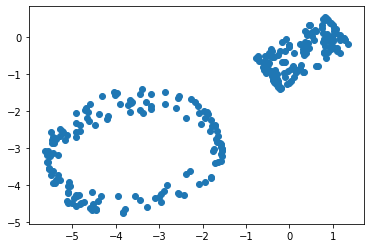

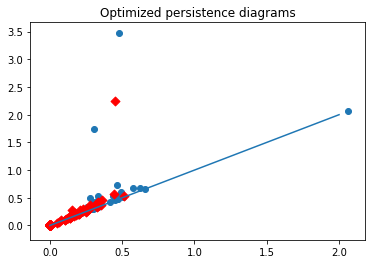

2.6097794


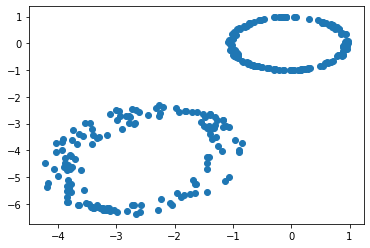

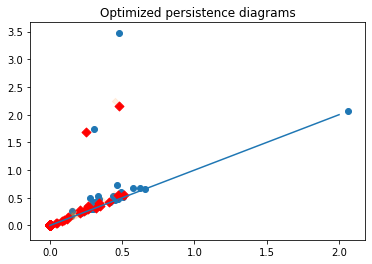

1.8519737


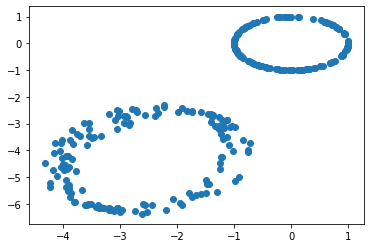

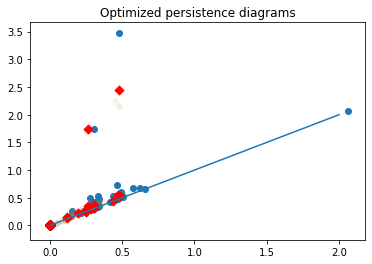

1.2056185


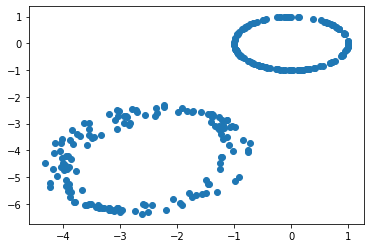

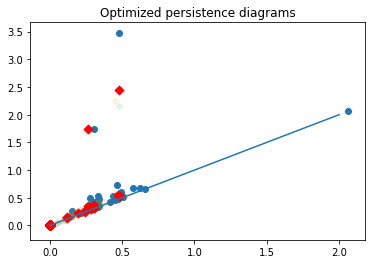

1.1861433


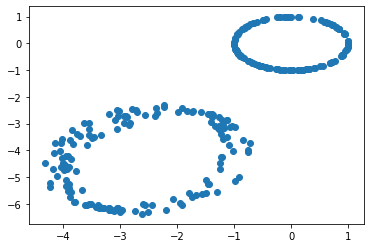

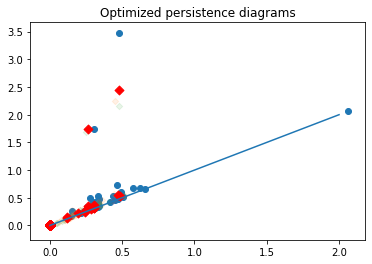

1.1851778


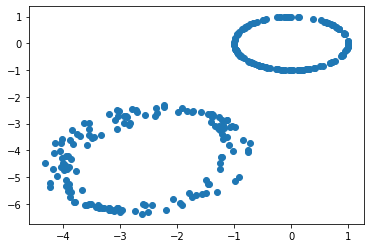

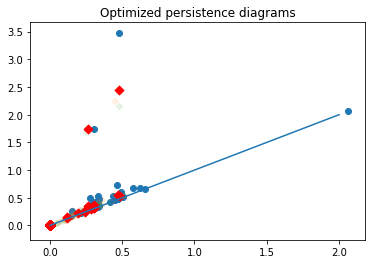

1.1837224


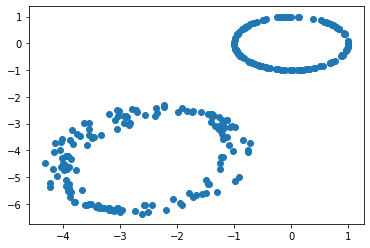

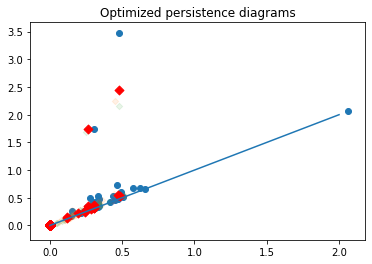

1.1814843


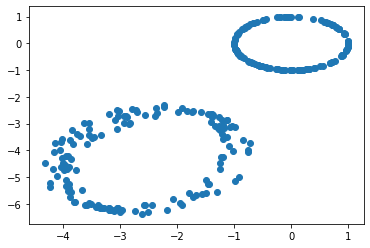

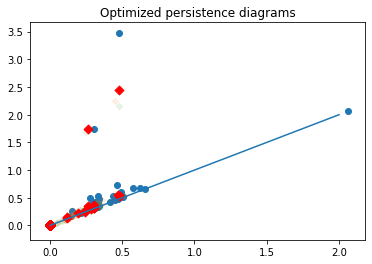

1.1781273


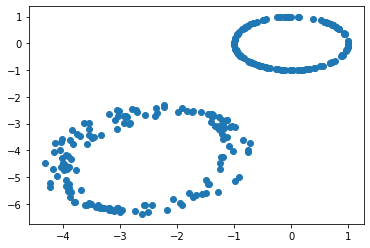

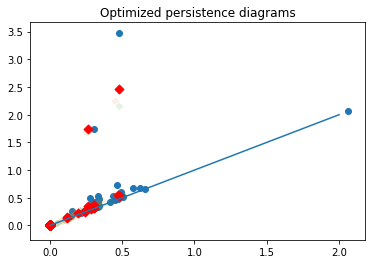

1.1730804


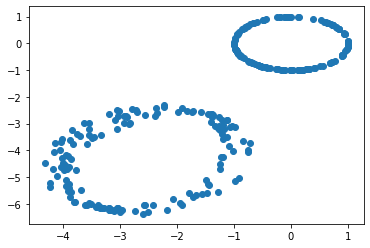

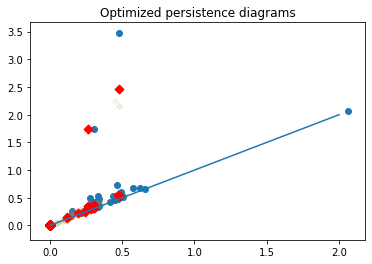

In [ ]:
losses, dgms = [], []
lr = 5
for epoch in range(10):
    opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
    if epoch<4:
        lr = 0.05*lr
    else:
        lr = lr*1.5
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        Zdgm = model.call()[1]
        Xdgm = model.call()[0]
        
        
        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    print(loss.numpy())
    
    losses.append(loss.numpy())
    Zdgmnow = model.call()[1]
    dgms.append(Zdgmnow)
    
    if epoch >-1:
        data=X@model.P.numpy()
        x2=data[:,0].tolist()
        y2=data[:,1].tolist()
        fig, ax = plt.subplots()
        ax.scatter(x2,y2)
        plt.show()
        
        D = Xdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1])
        
        
        for dg in dgms:
            plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
        plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
        plt.plot([0,2],[0,2])
        plt.title("Optimized persistence diagrams")
        plt.show()

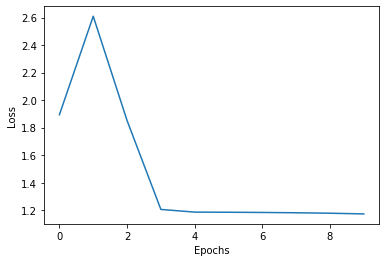

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Our Implementation

In [ ]:
def pd(X, max_dim =3):
  
  rips_complex = gd.RipsComplex(points=X, max_edge_length=100)
  simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
  diag = simplex_tree.persistence(min_persistence=0)

  gd.plot_persistence_barcode(diag)
  plt.show()

  gd.plot_persistence_diagram(diag)
  plt.show()


## Circle

Gudhi - Red = 0, Blue = 1, Green = 2 dimension holes

In [ ]:
circle = unif_sphere(n_samples=200,n_features=2,radius=1,plot=False)
const = np.array([np.random.random(1)[0]]*200)
const = const.reshape(1,200)
circ_embed3_const = np.concatenate([circle,const],axis=0)
X = np.array(np.mat(circ_embed3_const).T,dtype=np.float32)
ax = plt.subplot(111, projection='3d')
ax.scatter(circ_embed3_const[0],circ_embed3_const[1],circ_embed3_const[2]) 
plt.show()

NameError: ignored

In [ ]:
X=np.array(np.mat([X[0],X[1],X[2]]).T,dtype=np.float32)

In [ ]:
def pd(X, max_dim =3):
  
  rips_complex = gd.RipsComplex(points=X, max_edge_length=100)
  simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
  diag = simplex_tree.persistence(min_persistence=0)

  gd.plot_persistence_barcode(diag)
  plt.show()

  gd.plot_persistence_diagram(diag)
  plt.show()


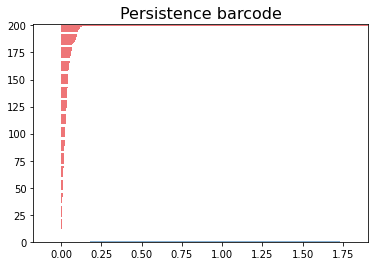

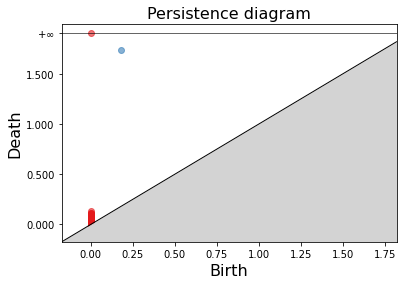

In [ ]:
pd(X)

## Sphere

In [ ]:
sphere = unif_sphere(n_samples=200,n_features=3,radius=1,plot=False)

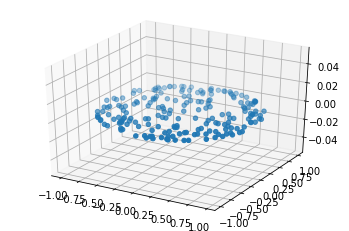

In [ ]:
X = sphere
ax = plt.subplot(111, projection='3d')
ax.scatter(X[0],X[1],X[2]) 
plt.show()

In [ ]:
X=np.array(np.mat([sphere[0],sphere[1],sphere[2]]).T,dtype=np.float32)

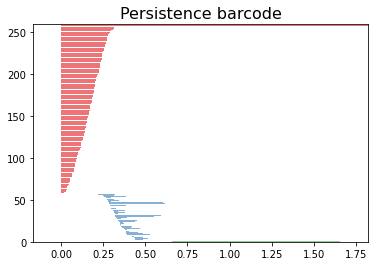

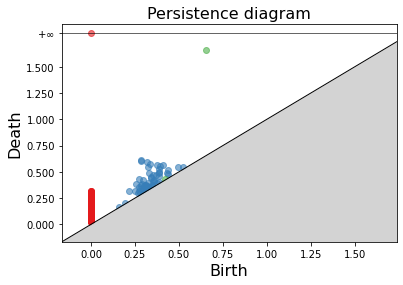

In [ ]:
pd(X)

### Zhaoyang's method

In [ ]:
st = gd.RipsComplex(points = X, 
                    max_edge_length = 100).create_simplex_tree(max_dimension=3)
st.persistence() #computes persistence intervals

#extract persistence intervals for specified dim
D = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)

In [ ]:
D = np.array(st.persistence_intervals_in_dimension(2), dtype=np.float32)

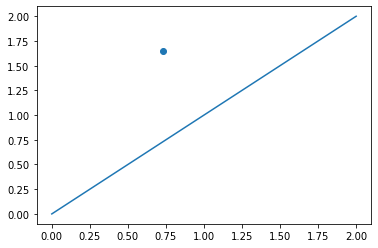

In [ ]:
plt.figure()
#plots birth and death times
plt.scatter(D[:,0], D[:,1])
#plots x=y
plt.plot([0,2], [0,2])
plt.show()

### Embedded Sphere 

In [ ]:
const = np.array([np.random.random(1)[0]]*200)
const = const.reshape(1,200)
sphere_embed4 = np.concatenate([sphere,const],axis=0)

In [ ]:
X=np.array(np.mat([sphere_embed4[0],sphere_embed4[1],sphere_embed4[2],sphere_embed4[3]]).T,dtype=np.float32)

In [ ]:
X.shape

(200, 4)

usetex mode requires TeX.


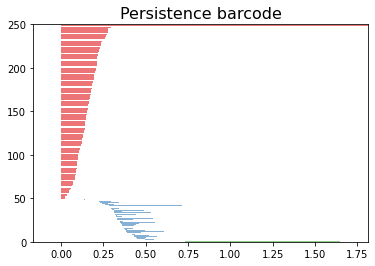

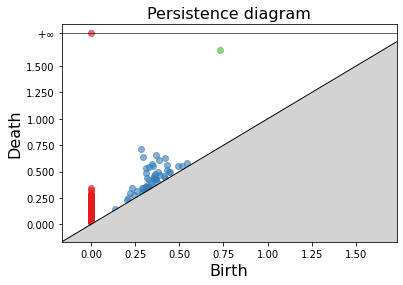

In [ ]:
pd(X)

## Dimension Reduction Functions 

### Zhaoyang's Helper Functions

In [6]:
#computing Sinkhorn distance <<<- estimation of wasserstein
def dmat(x, y):
    """
    :param x: (na, 2)
    :param y: (nb, 2)
    :return:
    """
    mmp1 = tf.tile(tf.expand_dims(x, axis=1), [1, y.shape[0], 1])  # (na, nb, 2)
    mmp2 = tf.tile(tf.expand_dims(y, axis=0), [x.shape[0], 1, 1])  # (na, nb, 2)

    mm = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(mmp1, mmp2)), axis=2))  # (na, nb)

    return mm
        
def sink(M, m_size, reg, numItermax=1000, stopThr=1e-9):
  # we assume that no distances are null except those of the diagonal of distances
  # M: extended cost matrix
  # reg: lambda

  a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
  b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

  # init data
  Nini = m_size[0]
  Nfin = m_size[1]

  u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
  v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

  K = tf.exp(-M / reg)  # (na, nb)

  Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

  cpt = tf.constant(0)
  err = tf.constant(1.0)

  c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

  def err_f1():
      # we can speed up the process by checking for the error only all the 10th iterations
      transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
      err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
      return err_

  def err_f2():
      return err

  def loop_func(cpt, u, v, err):
      KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
      v = tf.compat.v1.div(b,KtransposeU)  # (nb, 1)
      u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

      err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

      cpt = tf.add(cpt, 1)
      return cpt, u, v, err

  _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

  result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

  return result

### def *optimize_sinkhorn()*

In [4]:
def optimize_sinkhorn(X, old_dim=3, new_dim=2, holes_dim=1, epoch_num = 4):
  #construct Stiefel manifold
  S = manopt.manifolds.StiefelCanonical() #Stiefel manifold with the canonical metric, canonical = conventional

  #random P in Stiefel manifold as the initialized, P = projection matrix on manifold
  H = np.random.rand(old_dim, new_dim)
  u, s, vh = np.linalg.svd(H, full_matrices=False) #u, vh orthogonal matricies
  P = u @ vh  #initalize P, multiplying orthog * orthong = orthog P is 3x2

  #convert it into tensor with float 32
  Pinit = np.array(P, dtype=np.float32) 
  P = tf.Variable(initial_value=Pinit, trainable=True) #make P tensorflow variable, trainable = True 

  #assign the initialized P
  manopt.variable.assign_to_manifold(P, S) #make P cananonical steifel manifold 

  #construct main model and optimization model
  model = RipsModel(P=P, mel=12, dim=holes_dim, card = 20) #model class instance

  opt = manopt.optimizers.RiemannianSGD(learning_rate= 10) #Optimizer that implements the Riemannian SGD algorithm, class instance

  #keep track of loss and persistence diagrams after projection
  losses, dgms = [], []

  #lr = 10, learning rate
  for epoch in range(epoch_num+1):#learning iteration, 5 times 
      #opt = manopt.optimizers.RiemannianSGD(learning_rate = lr)
      #lr = 0.05*lr

      #Inside this scope, we call the model (forward pass) and compute the loss
      with tf.GradientTape() as tape:#computing gradient
          
          # Compute persistence diagram
          Zdgm = model.call()[1] #projected persistence diagram
          Xdgm = model.call()[0] #original persistence diagram
          npX = np.array(Xdgm)
          npZ = np.array(Zdgm)
          
          #Question: Why are all these functions defined in the loop? Can we take them out? 
          
          A=np.array([[1,-1],[-1,1]])
          # Compute persistence diagram

          
          # Loss is sum of squares of distances to the diagonal
          Morginal = dmat(Xdgm,Zdgm)
          
          n1,n2 = Morginal.shape
          Deltax=np.zeros(shape=(n1,1))
          Deltaz=np.zeros(shape=(1,n2+1))
          
          for i in range(n1):
              Deltax[i,0] = 1/2*npX[i,:]@A@npX[i,:].T
              
          for j in range(n2):
              Deltaz[0,j] = 1/2*npZ[j,:]@A@npZ[j,:].T
              

          M=tf.square(tf.concat([tf.concat([Morginal,Deltax],1),Deltaz],0))
          
          # Sinkhorn distance as loss
          loss = sink(M,(n1+1,n2+1),0.05)
          

      #Question: clarification,  loss used in gradients descent is sinkhorn distance?

      # Compute and apply gradients
      #Outside the scope, we retrieve the gradients of the weights of the model with regard to the loss

      #Question: what is the weights in our case? The P?
      gradients = tape.gradient(loss, model.trainable_variables)
      
      #Finally, we use the optimizer to update the weights of the model based on the gradients
      opt.apply_gradients(zip(gradients, model.trainable_variables))
      
      #loss
      print(loss.numpy())
      
      #persistence diagrams after transformation
      losses.append(loss.numpy()) #keeps tack of all losses 
      Zdgmnow = model.call()[1]
      dgms.append(Zdgmnow) #keep track of persistence diagrams
      
      if epoch >-1:
          data=X@model.P.numpy()
          x2=data[:,0].tolist()
          y2=data[:,1].tolist()
          z2=data[:,2].tolist()
          
          ax = plt.subplot(111, projection='3d')
          ax.scatter(x2,y2,z2) 
          # fig, ax = plt.subplots()
          # ax.scatter(x2,y2)
          plt.show()
          
          D = Xdgm.numpy()      
          plt.figure()
          plt.scatter(D[:,0], D[:,1])
          
          
          #Question for Zhaoyang: Why do you do this for loop?

          # for dg in dgms:
          #     plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)

          plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
          plt.plot([0,2],[0,2])
          plt.title("Optimized persistence diagrams")
          plt.show()

In [5]:
def generate_sphere(n_samples=200,n_features=2,n_padding=1):
  
  shape = unif_sphere(n_samples, n_features, radius=1,plot=False)
  const = np.random.random(n_padding).reshape((n_padding,1)) + np.zeros((n_padding,n_samples))
  # np.array([np.random.random(n_padding)[0]]*n_samples).reshape(n_padding,n_samples)
  X = np.array(np.mat(np.concatenate([shape,const],axis=0)).T,dtype=np.float32)
  return(X)


## Dimension Reduction Implementation

### Sphere

In [ ]:
X = generate_sphere(n_samples=200, n_features=2, n_padding=1)
np.random.seed(100)
optimize_sinkhorn(X, old_dim=3, new_dim=2, holes_dim=1,epoch_num=0)

KeyboardInterrupt: ignored

0.0063291346


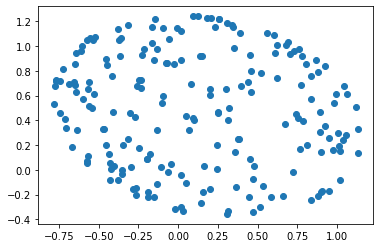

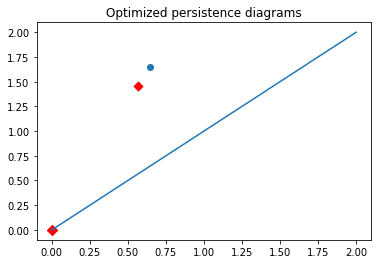

0.0020549893


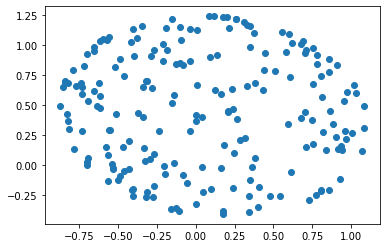

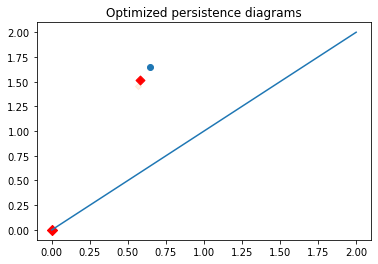

In [ ]:
X = generate_sphere(n_samples=200, n_features=3, n_padding=1)
np.random.seed(100)
optimize_sinkhorn(X, old_dim=4, new_dim=3, holes_dim=2,epoch_num=4)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
0.006329138


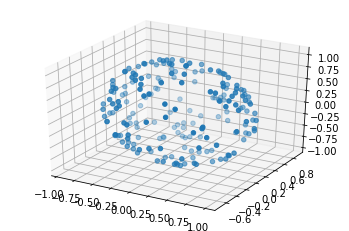

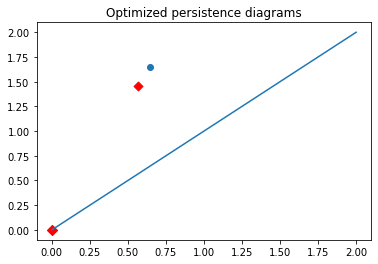

0.0020696719


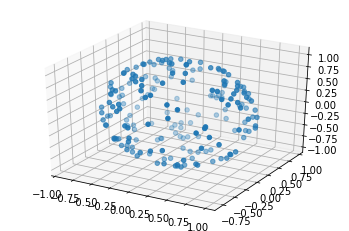

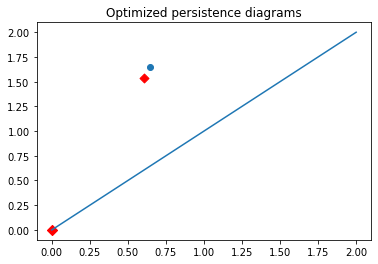

0.00071978074


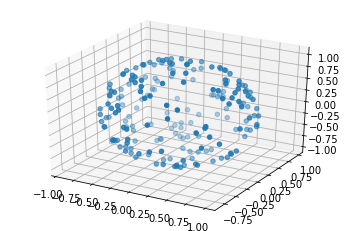

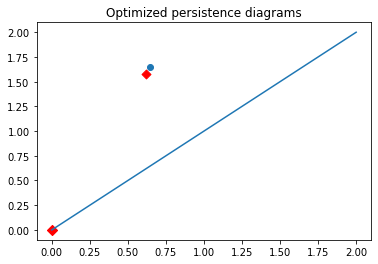

0.0003026441


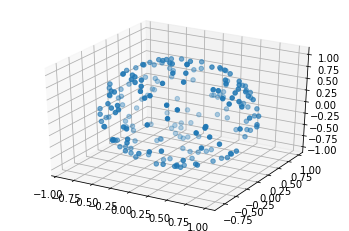

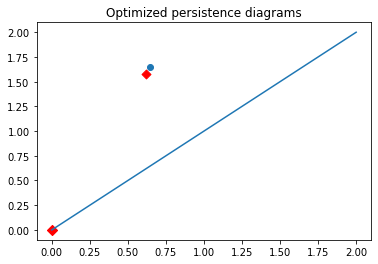

In [ ]:
X = generate_sphere(n_samples=200, n_features=3, n_padding=1)
np.random.seed(100)
optimize_sinkhorn(X, old_dim=4, new_dim=3, holes_dim=2,epoch_num=3)

### 4D Cylinder

0.29766855


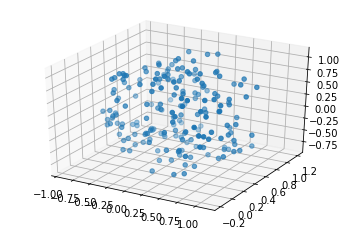

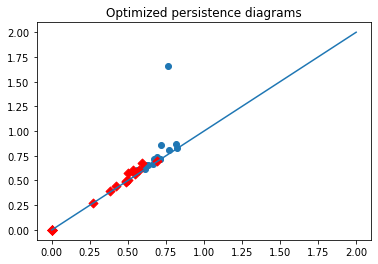

0.16283105


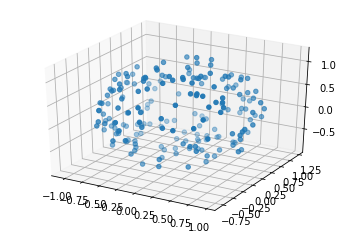

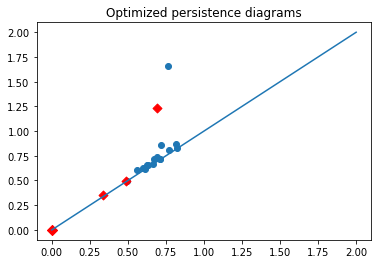

0.54342496


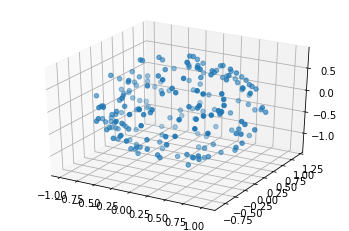

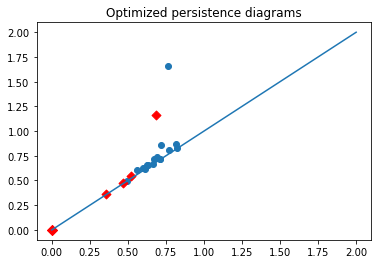

0.49433202


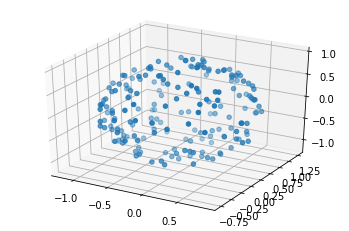

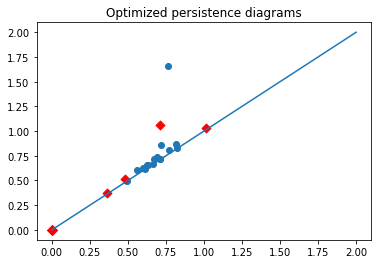

In [9]:
X = generate_sphere(n_samples=200, n_features=3, n_padding=2)
adder = np.random.uniform(0,1,200)
for i in range(200):
  X[i][3] = adder[i]
np.random.seed(100)
optimize_sinkhorn(X, old_dim=5, new_dim=3, holes_dim=2,epoch_num=3)

## Data Generation Functions

In [7]:
# import packages
import numpy as np
import scipy
from scipy.stats import norm 
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import math

## INVERSE TRANSFORM 

# generate sample from normal distribution using inverse transform sampling 
def InverseTransform(mu, sigma, n_samples):

  # start counter
  tic = time.perf_counter() 

  # simulate uniformly randomly distributed data of size n_samples
  u = np.random.uniform(0, 1, n_samples)

  # perform inverse transform sampling, scale by sigma, and translate by mu
  x = norm.ppf(u) * sigma + mu # quantile of standard normal distribution, scaled

  # end counter
  toc = time.perf_counter()

  # plot histogram of generated data
  plt.hist(x)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(x) #defaut comparison distribution is standard normal
  plt.show()

  # extract mean and standard deviation from generated data
  mu_new, sigma_new = norm.fit(x)

  # print given and generated parameters
  print("univariate inverse transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

  return x

## BOX-MULLER

# generate sample from normal distribution using Box-Muller Transform
def BoxMuller(mu,sigma,n,plot=False):
  
  # start counter
  tic = time.perf_counter() 

  # simulate theta and r
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)
  r = np.sqrt(-2*np.log(1-u1))
  theta = 2*np.pi*u2

  # calculcate x coordinate
  x = np.cos(theta)*r*sigma + mu

  # end counter
  toc = time.perf_counter() 

  if plot == True:

    # plot histogram of generated data
    plt.hist(x,density=True)
    plt.show()

    # plot qqplot of generated data
    sm.qqplot(x)
    plt.show()

    # mean and standard deviation from generated data
    mu_new, sigma_new = norm.fit(x)
    
    print("univariate Box Muller transform took {} seconds".format(toc - tic))
    print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
    print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

  return x

def BoxMullerAlt(n,mu=0,sigma=1):

  # start counter
  tic = time.perf_counter() 

  # simulate random uniformly distributed data of size n
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)

  # apply inverse cdf of exponential to u1
  s = -np.log(1-u1)  

  # transform u2 to theta
  theta = 2*np.pi*u2

  # convert s to r
  r = np.sqrt(2*s)

  # generate z1,z2 from r and theta
  z1, z2 = (r*np.cos(theta)*sigma + mu), (r*np.sin(theta)*sigma + mu)

  # end counter
  toc = time.perf_counter() 

  # plot histogram and scatterplot
  fig = plt.figure(figsize=plt.figaspect(0.4))
  ax = fig.add_subplot(1,2,1)
  ax.hist(z1)
  ax.hist(z2)
  ax = fig.add_subplot(1,2,2)
  ax.scatter(z1,z2,s=0.5)

  # plot qqplot of generated data
  sm.qqplot(z1)
  plt.show()
  sm.qqplot(z2)
  plt.show()

  # extract mean and standard deviation from generated data
  mu_1, sigma_1 = norm.fit(z1)
  mu_2,sigma_2 = norm.fit(z2)

  # print given and generated parameters
  print("univariate alternative Box Muller transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated z1: mu = {}, sigma = {}".format(mu_1, sigma_1)) # print generated parameters for z1
  print("generated z2: mu = {}, sigma = {}".format(mu_2, sigma_2)) # for z2


## CENTRAL LIMIT THEOREM

def CentralLimitTheorem(mu,sigma,n_means,n_samples):
  
  # start counter
  tic = time.perf_counter() 

  # generate data
  matrix = np.random.uniform(0,1,size=(n_means,n_samples))
  
  # calculcate sample means
  sampleMeans = matrix.sum(axis=0)/n_samples

  # standardize
  mean = np.mean(sampleMeans)
  sd = np.std(sampleMeans)
  standard = (sampleMeans - mean)/sd

  # scale by sigma, translate by mu
  normal = standard*sigma+mu
  
  # end counter
  toc = time.perf_counter() 

  # plot histogram of generated data
  plt.hist(normal)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(normal)
  plt.show()

  # mean and standard deviation from generated data
  mu_new = np.mean(normal)
  sigma_new = np.std(normal)

  # print given and generated parameters
  print("univariate CLT took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters


## MULTIVARIATE INVERSE TRANSFORM

np.random.seed(000)

# helper function to determine if inputted cov_matrix is valid covariance matrix
def is_cov_mat(x,tol=1e-8):

  # check if matrix is symmetric
  if np.array_equal(x,x.T): 

    # check if diagonal entries are non-negative  
    if any(n < 0 for n in x.diagonal()):
      return False
    
    # check if matrix is positive semi-definite
    else:      
      E = np.linalg.eigvalsh(x)
      return np.all(E > -tol)   
  else:
     return False

# generate sample from multivariate normal distribution using Inverse Transform Sampling
def multiNormalSample_ITS(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      u = np.random.uniform(0, 1, n_samples)
      z[d] = norm.ppf(u)
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov)
    print(eigval)
    print(eigvec)
    eigval_sqrt = np.diag(np.sqrt(eigval))
    print(eigval_sqrt)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time taken
    print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    # print eigenvalues
    print("the eigenvalues of the covariance matrix were {}".format(eigval)) 

    return x

  else:
    return("Inputted covariance matrix is invalid")


## MULTIVARIATE BOX-MULLER

# generate sample from multivariate normal distribution using Box Muller Transform
def multiNormalSample_BM(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      # simulate theta and r
      theta = np.random.uniform(0,2*np.pi,n_samples)
      r = np.sqrt(2*np.random.exponential(1,n_samples))

     # calculcate x coordinate
      z[d] = np.cos(theta)*r
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov_matrix)
    eigval_sqrt = np.diag(eigval*1/2)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # print eigenvalues
    # print("eigenvalues of covariance matrix:", eigval)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time take
    # print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    return x
  
  else:
    return("Inputted covariance matrix is invalid")


## MAKE BLOBS

def make_n_blobs(n_samples=100,n_features=2,centers=4,mu_coef=20,sigma_coef=4,user_mu=[],weights=[0.1,0.2,0.3,0.4]):
  # divide total number of samples by number of blobs (no remainder)
  n_samples //= centers # each blob will have this many data points

  # check if user has provided array of mean vectors
  manual_mu = False
  if np.shape(user_mu) == (centers,n_features): # (num blobs x num dimensions)
    # will use user inputted mu
    manual_mu = True
  else:
    # initialize mu
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize data matrix
  data = np.zeros((n_features,n_samples * centers))
  data_labels = np.zeros((n_samples * centers, 1))

  # plt.figure()
  # loop through blobs
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = max(2,np.random.randn()) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()

    # generate mean vector
    if manual_mu == True:
      mu = np.array(user_mu[i]).reshape((n_features,1)) # use user inputted mu
    else:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, n_samples, n_features) # use Box Muller    
    data[:,n_samples*i:n_samples*(i+1)] = X
    data_labels[n_samples*i:n_samples*(i+1)] = i

  toc = time.perf_counter() # end timer

  print("from scratch make blobs took {} seconds".format(toc - tic))

  # output full data matrix
  return(data, data_labels)


  ## MAKE BLOBS - MIXTURE MODEL

def mixture_make_blobs(n_samples=100,n_features=2,centers=4,
                       mu_coef=20,sigma_coef=4,mu_vec=[],
                       bins=[0.3,0.5,0.8,1]):
  # if user has not provided valid array of mean vectors, initialize
  manual_mu = True
  if np.shape(mu_vec) != (centers,n_features): # (num blobs x num dimensions)
    manual_mu = False
    mu_vec = []
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize covariance vector
  cov_vec = []

  # initialize data matrix
  data = np.zeros((n_features,n_samples))
  data_labels = np.zeros((n_samples, 1))

  # loop through blobs to create means and covariance
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = np.random.uniform(1,2) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()
    cov_vec.append(cov_matrix)

    # generate mean vector
    if manual_mu == False:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN
      mu_vec.append(mu.tolist())

  # loop through samples and draw from mixture distribution
  for j in range(n_samples):
    # generate random number in [0,1]
    alpha = np.random.uniform()

    # identify the index of weighted bin in which alpha belongs
    k = np.digitize(alpha,bins)

    # use mean and covariance from the chosen index
    mu = mu_vec[k]
    cov_matrix = cov_vec[k]

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, 1, n_features).flatten() # use Box Muller   
    data[:,j] = X
    data_labels[j] = k

  toc = time.perf_counter() # end timer

  print("mixture make blobs took {} seconds".format(toc - tic))
  # output full data matrix
  return(data, data_labels)


## GENERATE UNIFORM DATA ON SPHERE
def unif_sphere(n_samples=1000,n_features=3,radius=1,plot=False):
  # generate random normal data
  X = np.zeros((n_features,n_samples))

  for i in range(n_features):
    x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False).tolist()
    X[i,:] = x

  for i in range(n_samples):
    X[:,i] = X[:,i]/np.linalg.norm(X[:,i]) * radius
 
  if plot != False:
    for j in range(n_features):
      sm.qqplot(X[j,:], dist=scipy.stats.uniform)

  # plot
  if plot != False:
    if n_features == 2:
      plt.scatter(X[0,:],X[1,:])
    elif n_features == 3:
      fig = plt.figure(figsize=plt.figaspect(1))
      ax = fig.add_subplot(projection='3d')
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('z')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(0,45)
    else:
      print("no visualization available")

  return(X)

def uniform_sphere_polar(n_samples = 1000, r = 1,plot=False):

  phi = np.random.uniform(0,np.pi,n_samples)
  theta = np.random.uniform(0,2*np.pi,n_samples) 

  x=r*np.cos(phi)*np.sin(theta)
  y=r*np.sin(phi)*np.sin(theta)
  z=r*np.cos(theta)

  if plot != False:

    sm.qqplot(x, dist=scipy.stats.uniform)
    sm.qqplot(y, dist=scipy.stats.uniform)
    sm.qqplot(z, dist=scipy.stats.uniform)

    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)
  
  return(x,y,z)

def uniform_circle(n_samples = 1000, r =1,plot=False):
  theta = np.random.uniform(0,2*np.pi,n_samples)
  x = r*np.sin(theta)
  y=r*np.cos(theta)

  # sm.qqplot(x, dist=scipy.stats.uniform)

  # sm.qqplot(y, dist=scipy.stats.uniform)

  if plot != False:
    plt.figure()
    plt.scatter(x,y)
    plt.scatter(theta)
  
  return(x,y)

def uniform_sphere_from_normal(n_samples = 1000, r = 1,plot=False):

  x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  y=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  z=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)

  for i in range(n_samples):
    v=[x[i],y[i],z[i]]
    x[i]=x[i]/np.linalg.norm(v)
    y[i]=y[i]/np.linalg.norm(v)
    z[i]=z[i]/np.linalg.norm(v)

  x,y,z = x*r, y*r, z*r

  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)

  return(x,y,z)


## GENERATE UNIFORM DATA ON CYLINDER

def unif_cylinder(n_samples=1000,radius=1,height=100,n_features=3):
  # initialize data matrix
  X = np.zeros((n_features,n_samples))

  circ_dim = n_features - 1
  # generate a 2-d uniformly random circles
  X[:circ_dim,:] = unif_sphere(n_samples=n_samples,n_features=circ_dim,radius=1)
  
  # add uniformly random values of the third dimension to circles
  X[circ_dim,:] = np.random.uniform(0,height,n_samples).tolist()

  fig = plt.figure(figsize=plt.figaspect(0.5))
  ax = fig.add_subplot(1,2,2,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(90,0)

  ax = fig.add_subplot(1,2,1,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(45,45)
  return(ax)

## GENERATE UNIFORM DATA ON SQUARE

def uniform_square(side_length=1,n_samples=1000,center=[0,0],dim=2,angle_degree = 45):
    
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/4)
    
    top_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    top_y = np.repeat(dist_from_center,samples_per_side)
    top = np.asarray((top_x,top_y)).transpose()
    
    bottom_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    bottom_y = np.repeat(-dist_from_center,samples_per_side)
    bottom = np.asarray((bottom_x,bottom_y)).transpose()
    
    left_y  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    left_x = np.repeat(-dist_from_center,samples_per_side)
    left = np.asarray((left_x,left_y)).transpose()
    
    right_y = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    right_x = np.repeat(dist_from_center,samples_per_side)
    right = np.asarray((right_x,right_y)).transpose()
    
    X = np.concatenate((top,bottom,left,right))

    #rotate the square
    for i in range(n_samples):
        point = X[i]
        x = point[0]
        y = point[1]
        #rotation matrix
        X[i][0] = (x*np.cos(angle)) - (y*np.sin(angle))
        X[i][1] = (x*np.sin(angle)) + (y*np.cos(angle))

    #shift shape from the center
    X += center  

    #plot 
    plt.scatter(X[:,0],X[:,1])
    plt.axis("equal")


def square(side_length=1,n_samples=1000,dim1=True, dim2= True, dim3 = True, adder = 0,plot=False):

  X = np.zeros((3,n_samples)) + adder

  if dim1 == True:
    X[0,:] = np.random.uniform(0,side_length,n_samples) 
  if dim2 == True:  
    X[1,:] = np.random.uniform(0,side_length,n_samples)
  if dim3 == True:
    X[2,:] = np.random.uniform(0,side_length,n_samples)


  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(X[0,:],X[1,:],X[2,:])
    ax.view_init(45,45)

  return(X)


## GENERATE UNIFORM DATA ON CUBE
## FILLED CUBE

def cube(side_length=1,n_samples=10000):

  X = np.zeros((3,n_samples))

  X[0,:] = np.random.uniform(0,side_length,n_samples) 
  X[1,:] = np.random.uniform(0,side_length,n_samples) 
  X[2,:] = np.random.uniform(0,side_length,n_samples) 

  fig = plt.figure(figsize=plt.figaspect(1))
  ax = fig.add_subplot(projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(45,45)

## EMPTY CUBE

def empty_cube(side_length=1,n_samples=10000,center=[0,0,0],dim=2,angle_degree = 45,plot=True):
    
    center = np.array(center).reshape(3,1)
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/6)

 
    side1 = square(n_samples=samples_per_side, dim1=False) - dist_from_center
    side2 = square(n_samples=samples_per_side, dim1=False, adder = side_length) - dist_from_center

    side3 = square(n_samples=samples_per_side, dim2=False) - dist_from_center
    side4 = square(n_samples=samples_per_side, dim2=False, adder = side_length) - dist_from_center

    side5 = square(n_samples=samples_per_side, dim3=False) - dist_from_center
    side6 = square(n_samples=samples_per_side, dim3=False, adder = side_length) - dist_from_center

    #verify cube
    X_hollow = np.concatenate((side1,side2,side3,side4),axis=1) + center

    X = np.concatenate((side1,side2,side3,side4,side5,side6),axis=1) + center

    if plot != False:
      fig = plt.figure(figsize=plt.figaspect(0.5))
      ax = fig.add_subplot(1,2,1,projection='3d')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(45,45)

      ax = fig.add_subplot(1,2,2,projection='3d')
      ax.scatter(X_hollow[0,:],X_hollow[1,:],X_hollow[2,:])
      ax.view_init(90,0)
    
    return(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
